In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian
from scipy.signal import find_peaks

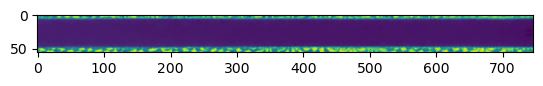

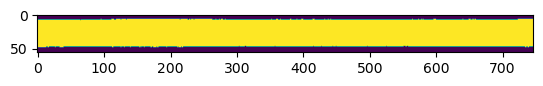

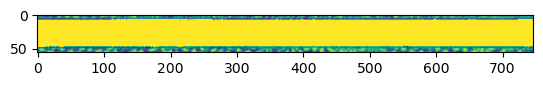

In [26]:
im = cv2.imread('fotos\\calibracion2.tif')

im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(im_gs)

_, im_th = cv2.threshold(im_gs, 60, 255, cv2.THRESH_BINARY)

im_th = cv2.bitwise_not(im_th)

y, x  = np.where(im_th == 255)

im_show = im_gs.copy()

im_show[y, x] = 255
plt.figure()
plt.imshow(im_th)
np.shape(im_th)

plt.figure()
plt.imshow(im_show)

41 40


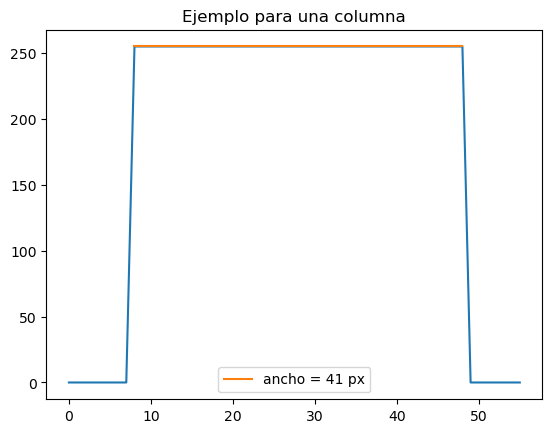

In [27]:
col = im_th[:,0]
bar = np.where(col==255)[0]
width = bar[-1] - bar[0]
print(len(bar), width)

plt.plot(col)
plt.title('Ejemplo para una columna')
plt.plot([bar[0], bar[-1]], [255, 255], label=f'ancho = {len(bar)} px')
plt.legend()

In [28]:
cols = [im_th[:, i] for i in range(np.shape(im_th)[1])]
len(cols)

widths = []
widths2 = []
for c in cols:
    bar = np.where(c==255)[0]
    width2 = len(bar)
    width = bar[-1] - bar[0]
    widths.append(width)
    widths2.append(width2)

mean_width = np.mean(widths)
width_std = np.std(widths)/np.sqrt(len(widths))

mean_width2 = np.mean(widths2)
width2_std = np.std(widths2)/np.sqrt(len(widths2))

PX_PER_MM = mean_width/8.275
PX_PER_MM2 = mean_width2/8.275

print(f'ancho promedio: {mean_width} +- {width_std}')
print(PX_PER_MM)

print(f'ancho2 promedio: {mean_width2} +- {width2_std}')
print(PX_PER_MM2)

print(width2_std/8.275, np.std(widths2)/8.275)

ancho promedio: 39.32262382864793 +- 0.02104967965151523
4.751978710410626
ancho2 promedio: 40.32262382864793 +- 0.02104967965151523
4.872824631860777
0.0025437679337178523 0.06952448640268089
